In [1]:
import time
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 128
num_classes = 10
torch.manual_seed(random_seed)


resize_transform = transforms.Compose([transforms.Resize((32,32)),
                                       transforms.ToTensor()])

train_dataset = datasets.MNIST(root='data',  
                               train=True, 
                               transform=resize_transform,
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=resize_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])


In [3]:
class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        self.grayscale = grayscale
        self.num_classes = num_classes
        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [4]:
model = LeNet5(num_classes, grayscale=True)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)
            
        # FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        
        # UPDATE MODEL PARAMETERS
        optimizer.step()
        
        # LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader, device=device)))

Epoch: 001/010 | Batch 0000/0469 | Cost: 2.3039
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.5588
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.2624
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.1554
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.2378
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.1102
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.1432
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.1057
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.1120
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.0653
Epoch: 001/010 | Train: 97.473%
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.1310
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.1184
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.1354
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.0532
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.0673
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.0141
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.0728
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0264
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.1054
Epoch: 002/010 | Batch 0450/0469 | Cost: 0.0821
Epoch: 0

In [6]:
with torch.set_grad_enabled(False): 
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=device)))

Test accuracy: 98.76%


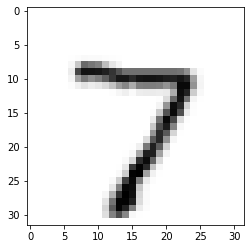

In [7]:
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features
    targets = targets
    break
    
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [9]:
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%
